Crypto ML research case: searching alfa from Twitter (X) sentiment, order book data, and volume

TODO:

- select token pairs and split into categories based on exchange, volume (30 days) and TVL 
- fetch token data from a single exchange for several different tokens (develop solution where time frames and token symbols can be adjusted)
- fetch twitter feed relating to the specified tokens, with timestamp dimension included
- train and test regression models for price predictions
- train and test classifiers for long/short actions

In [1]:
#libraries

import pandas as pd
import requests
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [2]:
api_url = "https://tradingstrategy.ai/api/"

In [3]:
chains = requests.get(api_url + "chains")
chain_names = [chain["chain_name"] for chain in chains.json()]
chain_slugs = [chain["chain_slug"] for chain in chains.json()]
chain_slug_string = ",".join(chain_slugs)

print(chains.json())
selected_chain = chain_slugs[0]

[{'chain_id': 1, 'chain_slug': 'ethereum', 'chain_name': 'Ethereum', 'chain_logo': 'https://upload.wikimedia.org/wikipedia/commons/0/05/Ethereum_logo_2014.svg', 'exchanges': 534}, {'chain_id': 56, 'chain_slug': 'binance', 'chain_name': 'BNB Smart Chain', 'chain_logo': 'https://hv4gxzchk24cqfezebn3ujjz6oy2kbtztv5vghn6kpbkjc3vg4rq.arweave.net/fgp9wHyH92hION8E6CuPtUNbmiTlqsl23QbQlwA8cZQ', 'exchanges': 3216}, {'chain_id': 137, 'chain_slug': 'polygon', 'chain_name': 'Polygon', 'chain_logo': 'https://hv4gxzchk24cqfezebn3ujjz6oy2kbtztv5vghn6kpbkjc3vg4rq.arweave.net/nLW0IfMZnhhaqdN1AbzC4d1NLZSpBlIMEHhXq-KcOws', 'exchanges': 923}, {'chain_id': 43114, 'chain_slug': 'avalanche', 'chain_name': 'Avalanche C-chain', 'chain_logo': 'https://cryptologos.cc/logos/avalanche-avax-logo.svg', 'exchanges': 177}, {'chain_id': 42161, 'chain_slug': 'arbitrum', 'chain_name': 'Arbitrum One', 'chain_logo': 'https://offchainlabs.com/wp-content/themes/offchain/images/home/arbitrum/arbirtum_logo.svg', 'exchanges': 35

In [4]:
# get Ethereum exchanges without zero volume 

eth_exchanges = requests.get(api_url + f"exchanges?chain_slug={selected_chain}&sort=usd_volume_30d&direction=desc&filter_zero_volume=true")
print(eth_exchanges.json())
eth_exc_names = [exc["exchange_slug"]for exc in eth_exchanges.json()["exchanges"]]
eth_exc_vol = [exc["usd_volume_30d"]for exc in eth_exchanges.json()["exchanges"]]
eth_exc_id = [exc["exchange_id"]for exc in eth_exchanges.json()["exchanges"]]
df_eth_exc = pd.DataFrame(data={"vol":eth_exc_vol, "name": eth_exc_names}, index=eth_exc_id)
df_eth_exc.head()

{'exchanges': [{'exchange_id': '3681', 'exchange_slug': 'uniswap-v3', 'chain_slug': 'ethereum', 'chain_name': 'Ethereum', 'human_readable_name': 'Uniswap v3', 'chain_id': 1, 'address': '0x1f98431c8ad98523631ae4a59f267346ea31f984', 'usd_volume_30d': 19244138679.965527, 'exchange_type': 'uniswap_v3', 'notable': True, 'pair_count': 20299}, {'exchange_id': '1', 'exchange_slug': 'uniswap-v2', 'chain_slug': 'ethereum', 'chain_name': 'Ethereum', 'human_readable_name': 'Uniswap v2', 'chain_id': 1, 'address': '0x5c69bee701ef814a2b6a3edd4b1652cb9cc5aa6f', 'usd_volume_30d': 5194410170.411074, 'exchange_type': 'uniswap_v2', 'notable': True, 'pair_count': 308973}, {'exchange_id': '22', 'exchange_slug': 'sushi', 'chain_slug': 'ethereum', 'chain_name': 'Ethereum', 'human_readable_name': 'Sushi', 'chain_id': 1, 'address': '0xc0aee478e3658e2610c5f7a4a2e1777ce9e4f2ac', 'usd_volume_30d': 253668311.58562857, 'exchange_type': 'uniswap_v2', 'notable': True, 'pair_count': 3915}, {'exchange_id': '314', 'excha

,vol,name
3681,1.924414e+10,uniswap-v3
1,5.194410e+09,uniswap-v2
22,2.536683e+08,sushi
314,1.310076e+08,twap
231,2.376002e+07,shiba-swap


Select three highest volume exchanges

In [5]:
selected_exchanges = df_eth_exc.iloc[0:5,:]
print(selected_exchanges)

               vol        name
3681  1.924414e+10  uniswap-v3
1     5.194410e+09  uniswap-v2
22    2.536683e+08       sushi
314   1.310076e+08        twap
231   2.376002e+07  shiba-swap


Selected pairs for token ETH (WETH)

In [6]:
exc_slug_string = ",".join(selected_exchanges["name"].to_list())
pairs_n = 20
pairs = requests.get(api_url + f"pairs?exchange_slugs={exc_slug_string}&chain_slugs={chain_slug_string}&page=0&page_size={pairs_n}&sort=volume_30d&direction=desc&filter=min_liquidity_1M&eligible_only=true&format=json")
pair_id = [pair["pair_id"] for pair in pairs.json()["results"]]
pair_slug = [pair["pair_slug"] for pair in pairs.json()["results"]]
pair_exc = [pair["exchange_slug"] for pair in pairs.json()["results"]]
pair_df = pd.DataFrame(data={"pair_slug" : pair_slug, "pair_exchange": pair_exc}, index=pair_id)

Get OHLCV data for pairs in all exchanges in the specified chain for selected timeframe

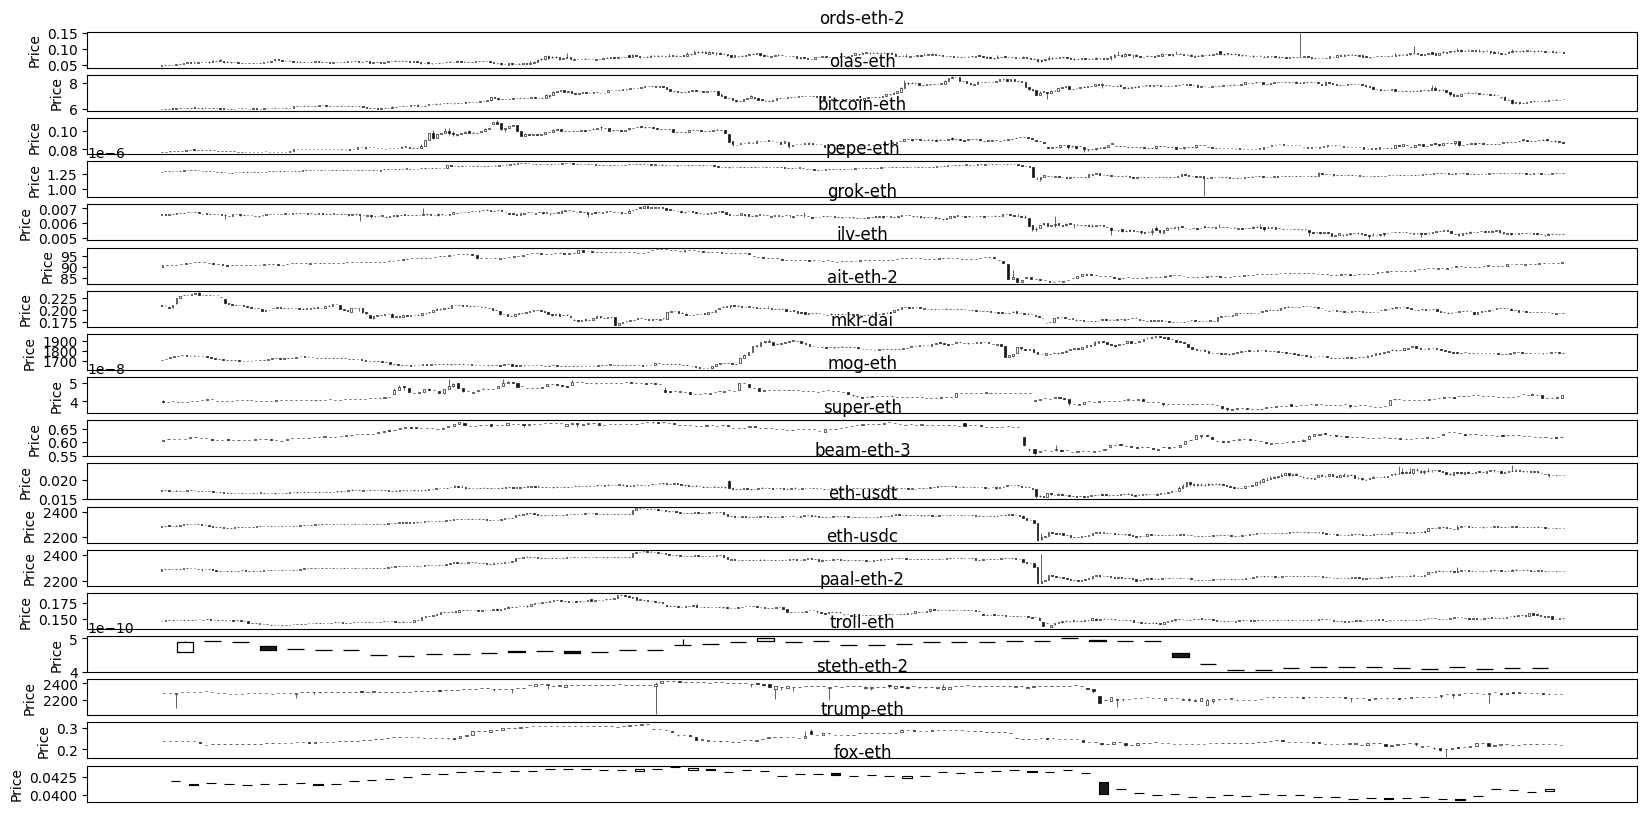

In [7]:
start_time = "2024-01-01"
end_time = "2024-01-05"    
time_bucket = "15m"
pair_id_string = ",".join(pair_df.index.values.astype(str))
data_req = requests.get(api_url + f"candles?pair_ids={pair_id_string}&time_bucket={time_bucket}&candle_type=price&start={start_time}&end={end_time}")
data = data_req.json()
ohlcv_dfs = {}


for key, value in data.items():
    ts = [val["ts"] for val in value]
    open = [val["o"] for val in value]
    high = [val["h"] for val in value]
    low = [val["l"] for val in value]
    close = [val["c"] for val in value]
    volume = [val["v"] for val in value]
    df = pd.DataFrame(data={"Open": open, "High": high, "Low": low, "Close": close, "Volume": volume}, index=pd.to_datetime(ts, format='%Y-%m-%dT%H:%M:%S'))
    ohlcv_dfs[pair_df.loc[int(key), "pair_slug"]] = df

fig, axs = plt.subplots(len(ohlcv_dfs.keys()), figsize=(20,10))

for i, k in enumerate(ohlcv_dfs.keys()):
    mpf.plot(ohlcv_dfs[k], type="candle", volume=False, ax=axs[i])
    axs[i].set_title(k)
    axs[i].set_xticks([])

plt.show()

Dataset analysis without Twitter data

In [8]:

#master dataframe
columns = list(ohlcv_dfs[list(ohlcv_dfs.keys())[0]].columns)
all_df = pd.DataFrame(data={}, index=ohlcv_dfs[list(ohlcv_dfs.keys())[0]].index.values)
for key, value in ohlcv_dfs.items():
    for col in columns:
        all_df[str(key) + "_" + str(col)] = ohlcv_dfs[key][col]

In [9]:
# fill NaNs

all_df = all_df.fillna(method="ffill").fillna(method="bfill")


C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_4036\1690990188.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df = all_df.fillna(method="ffill").fillna(method="bfill")


<Axes: >

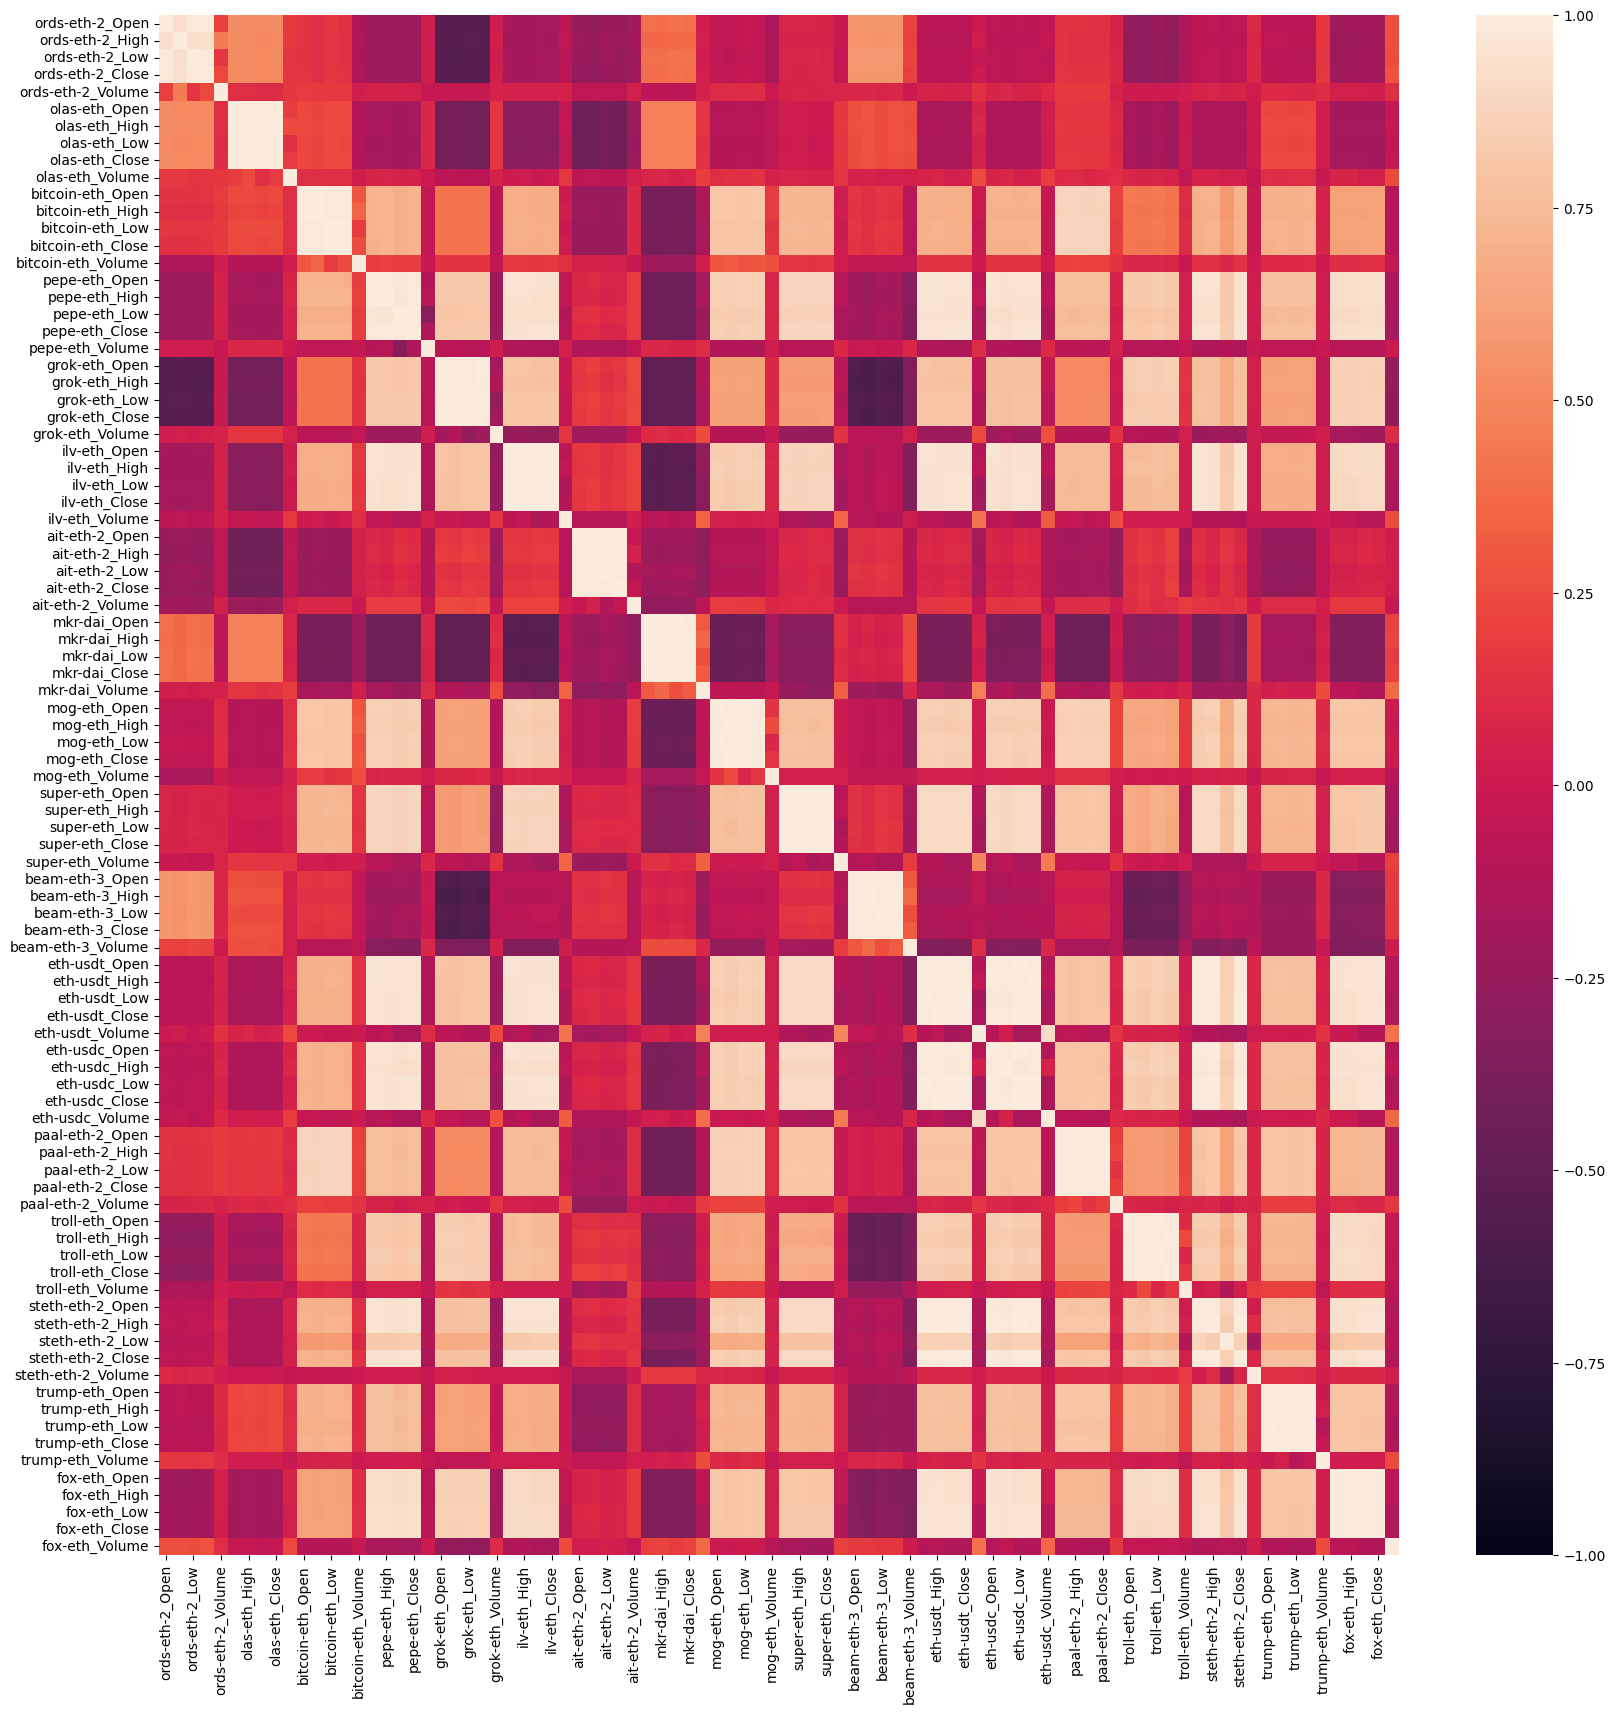

In [10]:
plt.figure(figsize=(20, 20)) 
sns.heatmap(all_df.corr(), vmin=-1, vmax=1, annot=False)

In [11]:
target = "eth-usdt_Close"
test_share = 0.2
target_index = all_df.columns.get_loc(target)
X = all_df.drop(columns=[target]).shift(1).fillna(method="bfill")
y = all_df[target].to_numpy().reshape(-1, 1)
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=test_share, shuffle=False)

print("X_train :",X_train.shape,"y_train :",y_train.shape)
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_train : (308, 89) y_train : (308, 1)
X_test : (77, 89) y_test : (77, 1)


C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_4036\1802969491.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = all_df.drop(columns=[target]).shift(1).fillna(method="bfill")


Baseline model: Simple moving average of T periods with K smoothing

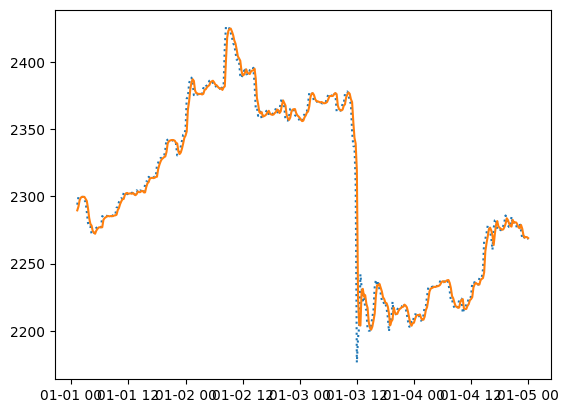

In [12]:
span = 2
periods = 5
emw = all_df[target].shift(1).ewm(span=span, adjust=False, min_periods=periods).mean().dropna()
all_df_shifted = all_df[target][periods:]
plt.figure()
plt.plot(all_df_shifted, linestyle="dotted")
plt.plot(emw)

In [13]:
mean_squared_error(all_df_shifted, emw)


91.06714447652661

In [14]:
def create_simple_rnn(X_train, y_train, dense_units, hidden_units, input_shape, activations, epochs, batch_size):
    # initializing the RNN
    regressor = Sequential()
    
    # adding RNN layers and dropout regularization
    regressor.add(SimpleRNN(units = hidden_units, 
                            activation = activations[0],
                            return_sequences = True,
                            input_shape = input_shape))
    regressor.add(Dropout(0.2))
    
    regressor.add(SimpleRNN(units = hidden_units, 
                            activation = activations[0],
                            return_sequences = True))
    
    regressor.add(SimpleRNN(units = hidden_units, 
                            activation = activations[0],
                            return_sequences = True))
    
    regressor.add( SimpleRNN(units = hidden_units))
    
    # adding the output layer
    regressor.add(Dense(units = dense_units, activation=activations[1]))
    
    # compiling RNN
    regressor.compile(optimizer = "adam", 
                    loss = "mean_squared_error")
    
    # fitting the model
    regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)
    regressor.summary()
    return regressor


In [15]:
simple_rnn = create_simple_rnn(X_train, y_train, 1, 32, (X_train.shape[1],1), ["relu", "linear"], 10, 10)



Epoch 1/10

31/31 [==============================] - 8s 61ms/step - loss: 0.0568
Epoch 2/10
31/31 [==============================] - 2s 64ms/step - loss: 0.0171
Epoch 3/10
31/31 [==============================] - 2s 67ms/step - loss: 0.0107
Epoch 4/10
31/31 [==============================] - 2s 60ms/step - loss: 0.0110
Epoch 5/10
31/31 [==============================] - 2s 61ms/step - loss: 0.0078
Epoch 6/10
31/31 [==============================] - 2s 58ms/step - loss: 0.0069
Epoch 7/10
31/31 [==============================] - 2s 59ms/step - loss: 0.0076
Epoch 8/10
31/31 [==============================] - 2s 60ms/step - loss: 0.0052
Epoch 9/10
31/31 [==============================] - 2s 60ms/step - loss: 0.0046
Epoch 10/10
31/31 [==============================] - 2s 62ms/step - loss: 0.0044
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 89, 32) 

In [16]:
simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 89, 32)            1088      
                                                                 
 dropout (Dropout)           (None, 89, 32)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 89, 32)            2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 89, 32)            2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7361 (28.75 KB)
Trainable params: 7361 (28

In [17]:
y_preds_test_simple_rnn = simple_rnn.predict(X_test)
y_preds_train_simple_rnn = simple_rnn.predict(X_train)


10/10 [==============================] - 0s 17ms/step


test RMSE 498.75614693437745
train RMSE 204.34169359590538


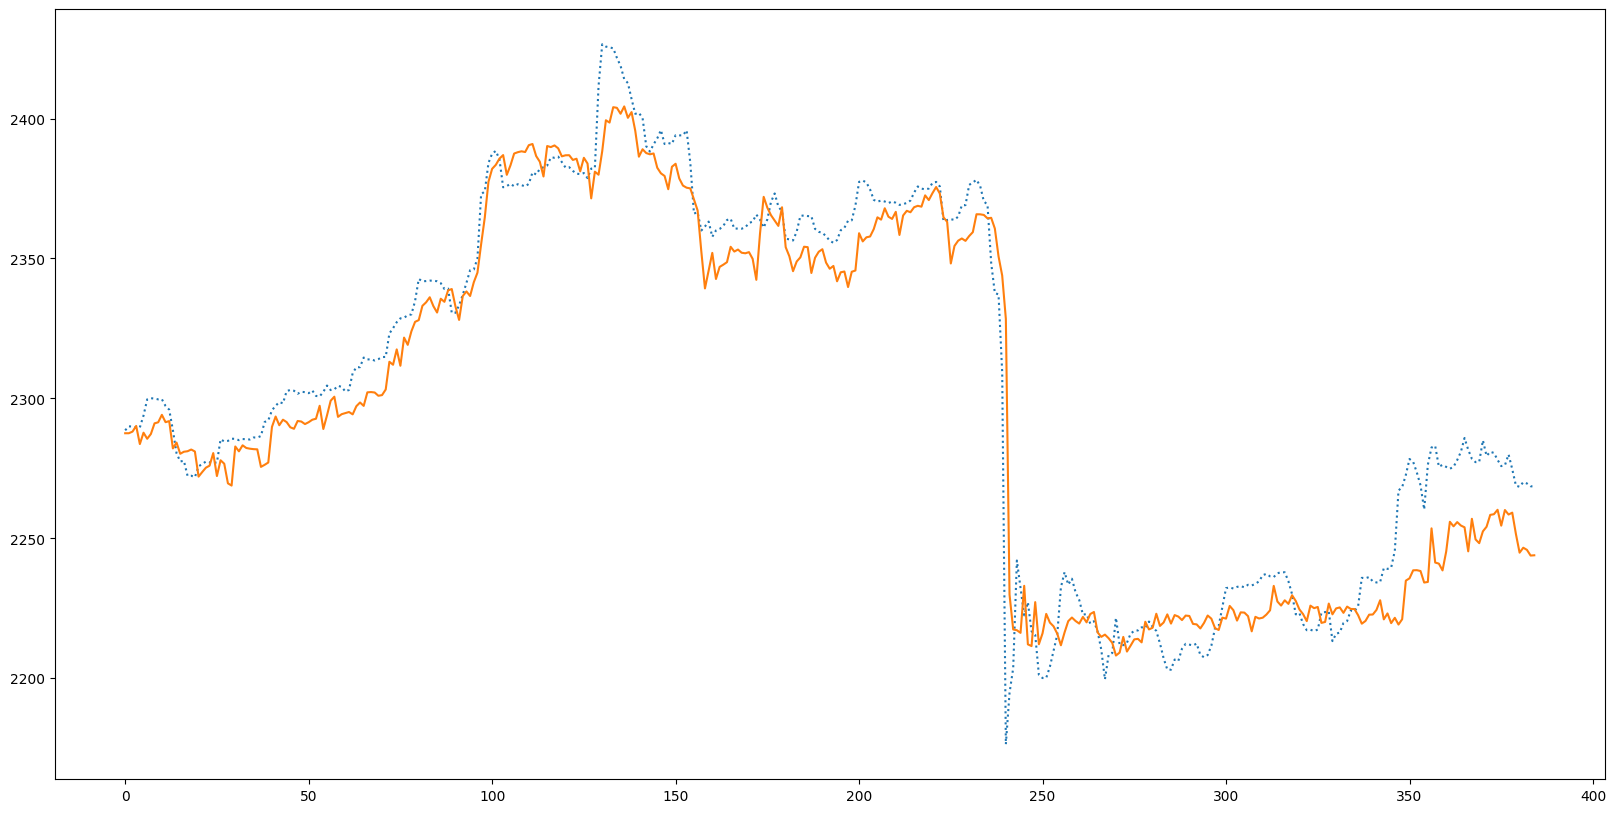

In [18]:
y_preds_train_rescaled = scaler.inverse_transform(y_preds_train_simple_rnn) 
y_preds_test_rescaled = scaler.inverse_transform(y_preds_test_simple_rnn) 
plt.figure(figsize=(20,10))
plt.plot(np.concatenate((scaler.inverse_transform(y_train), scaler.inverse_transform(y_test)), axis=0), linestyle="dotted")
plt.plot(np.concatenate((y_preds_train_rescaled, y_preds_test_rescaled), axis=0))
print("test RMSE",  mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_preds_test_simple_rnn)))
print("train RMSE",  mean_squared_error(scaler.inverse_transform(y_train), scaler.inverse_transform(y_preds_train_simple_rnn)))